## Problem Statement:

This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.


#### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns",None)

from numpy import mean
from numpy import std
from numpy import absolute

import warnings
warnings.filterwarnings('ignore')

#Importing Visualising Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Importing DataCleaning Libraries
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Importing Predictive Models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import RepeatedKFold

#Importing model evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import joblib

In [2]:
# Loading Dataset
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/Dataset2/main/temperature.csv")
df.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,30-06-2013,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,30-06-2013,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,30-06-2013,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,0.204091,0.142125,0.0,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,30-06-2013,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,0.0,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,30-06-2013,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,0.0,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [3]:
#Analysing Datatypes of our attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


### About Dataset :  
__Features:__

1. station - used weather station number: 1 to 25
2. Date - Present day: yyyy-mm-dd ('2013-06-30' to '2017-08-30')
3. Present_Tmax - Maximum air temperature between 0 and 21 h on the present day (Â°C): 20 to 37.6
4. Present_Tmin - Minimum air temperature between 0 and 21 h on the present day (Â°C): 11.3 to 29.9
5. LDAPS_RHmin - LDAPS model forecast of next-day minimum relative humidity (%): 19.8 to 98.5
6. LDAPS_RHmax - LDAPS model forecast of next-day maximum relative humidity (%): 58.9 to 100
7. LDAPS_Tmax_lapse - LDAPS model forecast of next-day maximum air temperature applied lapse rate (Â°C): 17.6 to 38.5
8. LDAPS_Tmin_lapse - LDAPS model forecast of next-day minimum air temperature applied lapse rate (Â°C): 14.3 to 29.6
9. LDAPS_WS - LDAPS model forecast of next-day average wind speed (m/s): 2.9 to 21.9
10. LDAPS_LH - LDAPS model forecast of next-day average latent heat flux (W/m2): -13.6 to 213.4
11. LDAPS_CC1 - LDAPS model forecast of next-day 1st 6- 6-hour split average precipitation (12-17 h) (%): 0 to 15.8
18. LDAPS_PPT4 - LDAPS model forecast of next-day 4thhour split average cloud cover (0-5 h) (%): 0 to 0.97
12. LDAPS_CC2 - LDAPS model forecast of next-day 2nd 6-hour split average cloud cover (6-11 h) (%): 0 to 0.97
13. LDAPS_CC3 - LDAPS model forecast of next-day 3rd 6-hour split average cloud cover (12-17 h) (%): 0 to 0.98
14. LDAPS_CC4 - LDAPS model forecast of next-day 4th 6-hour split average cloud cover (18-23 h) (%): 0 to 0.97
15. LDAPS_PPT1 - LDAPS model forecast of next-day 1st 6-hour split average precipitation (0-5 h) (%): 0 to 23.7
16. LDAPS_PPT2 - LDAPS model forecast of next-day 2nd 6-hour split average precipitation (6-11 h) (%): 0 to 21.6
17. LDAPS_PPT3 - LDAPS model forecast of next-day 3rd 6-hour split average precipitation (18-23 h) (%): 0 to 16.7
19. lat - Latitude (Â°): 37.456 to 37.645
20. lon - Longitude (Â°): 126.826 to 127.135
21. DEM - Elevation (m): 12.4 to 212.3
22. Slope - Slope (Â°): 0.1 to 5.2
23. Solar radiation - Daily incoming solar radiation (wh/m2): 4329.5 to 5992.9

__2 target variables:__ 

1. Next_Tmax: Next day maximum temperature
2. Next_Tmin: Next day  minimum temperature

### Exploratory Data Analysis (EDA)

In [4]:
# Shape of our dataset
print('Shape of test dataset is Rows: {} Columns: {}'.format(df.shape[0], df.shape[1]))

Shape of test dataset is Rows: 7752 Columns: 25


In [5]:
#Statistical Overview of our Numerical Features
df.describe()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
count,7750.000000,7682.000000,7682.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7725.000000,7725.000000
mean,13.000000,29.768211,23.225059,56.759372,88.374804,29.613447,23.512589,7.097875,62.505019,0.368774,0.356080,0.318404,0.299191,0.591995,0.485003,0.278200,0.269407,37.544722,126.991397,61.867972,1.257048,5341.502803,30.274887,22.932220
std,7.211568,2.969999,2.413961,14.668111,7.192004,2.947191,2.345347,2.183836,33.730589,0.262458,0.258061,0.250362,0.254348,1.945768,1.762807,1.161809,1.206214,0.050352,0.079435,54.279780,1.370444,429.158867,3.128010,2.487613
min,1.000000,20.000000,11.300000,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.456200,126.826000,12.370000,0.098475,4329.520508,17.400000,11.300000
25%,7.000000,27.800000,21.700000,45.963543,84.222862,27.673499,22.089739,5.678705,37.266753,0.146654,0.140615,0.101388,0.081532,0.000000,0.000000,0.000000,0.000000,37.510200,126.937000,28.700000,0.271300,4999.018555,28.200000,21.300000
50%,13.000000,29.900000,23.400000,55.039024,89.793480,29.703426,23.760199,6.547470,56.865482,0.315697,0.312421,0.262555,0.227664,0.000000,0.000000,0.000000,0.000000,37.550700,126.995000,45.716000,0.618000,5436.345215,30.500000,23.100000
75%,19.000000,32.000000,24.900000,67.190056,93.743629,31.710450,25.152909,8.032276,84.223616,0.575489,0.558694,0.496703,0.499489,0.052525,0.018364,0.007896,0.000041,37.577600,127.042000,59.832400,1.767800,5728.316406,32.600000,24.600000
max,25.000000,37.600000,29.900000,98.524734,100.000153,38.542255,29.619342,21.857621,213.414006,0.967277,0.968353,0.983789,0.974710,23.701544,21.621661,15.841235,16.655469,37.645000,127.135000,212.335000,5.178230,5992.895996,38.900000,29.800000


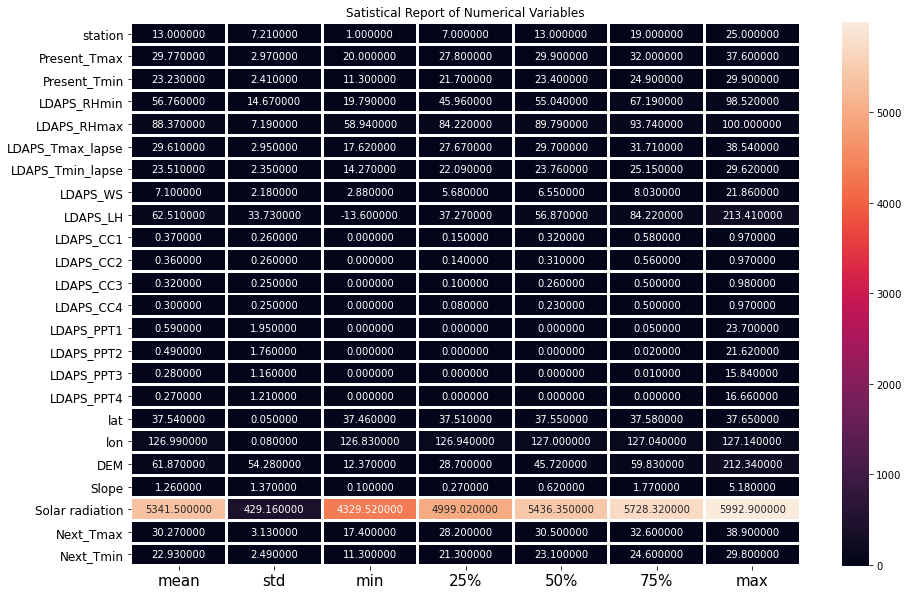

In [6]:
#visualizing statistical description of dataset
plt.figure(figsize = (15,10))
sns.heatmap(round(df.describe()[1:].transpose(),2),linewidth = 2,annot= True, fmt = "f")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)
plt.title("Satistical Report of Numerical Variables")
plt.show()

- station :
    - mean : 13
    - std : 7.21 
    - min : 1
    - max : 25
 
 
- Present Tmax :
    - mean : 29.77
    - std : 2.97
    - min : 20
    - max : 37.60
   
   
- Present Tmin :
    - mean : 23.23
    - std : 2.41
    - min : 11.3
    - max : 29.9
 
 
- LDAPS_RHmin :
    - mean : 56.76
    - std : 14.67
    - min : 19.79
    - max : 98.52
 
 
- LDAPS_RHmax :
    - mean : 88.37
    - std : 7.19
    - min : 58.94
    - max : 100
 
 
- LDAPS_Tmax_lapse :
    - mean : 29.61
    - std : 2.95
    - min : 17.62
    - max : 38.52
 
 
- LDAPS_Tmin-lapse :
    - mean : 23.51
    - std : 2.35
    - min : 14.27
    - max : 29.62
    

- LDAPS_WH :
    - mean : 7.1
    - std : 2.18
    - min : 2.88
    - max : 21.86


- LDAPS_LH :
    - mean : 62.51
    - std : 33.73
    - min : -13.60
    - max : 213.14
    

- LDAPS_CC1 :
    - mean : 0.37
    - std : 0.26
    - min : 0
    - max : 0.97
    

- LDAPS_CC2 :
    - mean : 0.36
    - std : 0.26
    - min : 0
    - max : 0.97 


- LDAPS_CC3 :
    - mean : 0.32
    - std : 0.25
    - min : 0
    - max : 0.98


- LDAPS_CC4 : 
    - mean : 0.30
    - std : 0.25
    - min : 0
    - max : 0.97


- LDAPS_PPT1 :
    - mean : 0.59
    - std : 1.95
    - min : 0
    - max : 23.7
    

- LDAPS_PPT2 :
    - mean : 0.49
    - std : 1.76
    - min : 0
    - max : 21.62


- LDAPS_PPt3 :
    - mean : 0.28
    - std : 1.16
    - min :  0
    - max : 15.84


- LDAPS_PPT4 :
    - mean : 0.27
    - std : 1.21 
    - min : 0
    - max : 16.666
    

- lat :
    - mean : 37.54
    - std : 0.05
    - min : 37.47
    - max : 37.65


- lon :
    - mean : 126.99
    - std : 0.08
    - min : 126.83
    - max : 127.46


- DEM :
    - mean : 61.87
    - std : 54.28
    - min : 12.37
    - max : 212.34


- slope :
    - mean : 1.26
    - std : 1.37
    - min : 0.1
    - max : 5.18


- Solar Radiation :
    - mean : 5341.5
    - std : 429.16
    - min : 4329.52
    - max : 5992.9


- Next Tmax :
    - mean : 30.27
    - std : 30.13
    - min : 17.4
    - max : 38.90


- Next Tmin :
    - mean : 22.93
    - std : 2.49
    - min : 11.30
    - max : 29.80

In [7]:
#Checking for null values

df.isna().sum()

station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64

In [8]:
#Checking for null Values to treat them
print("\nMissing values in percentage: \n",df.isnull().sum()/df.shape[0]*100)
#show values in percentage


Missing values in percentage: 
 station             0.025800
Date                0.025800
Present_Tmax        0.902993
Present_Tmin        0.902993
LDAPS_RHmin         0.967492
LDAPS_RHmax         0.967492
LDAPS_Tmax_lapse    0.967492
LDAPS_Tmin_lapse    0.967492
LDAPS_WS            0.967492
LDAPS_LH            0.967492
LDAPS_CC1           0.967492
LDAPS_CC2           0.967492
LDAPS_CC3           0.967492
LDAPS_CC4           0.967492
LDAPS_PPT1          0.967492
LDAPS_PPT2          0.967492
LDAPS_PPT3          0.967492
LDAPS_PPT4          0.967492
lat                 0.000000
lon                 0.000000
DEM                 0.000000
Slope               0.000000
Solar radiation     0.000000
Next_Tmax           0.348297
Next_Tmin           0.348297
dtype: float64


<AxesSubplot:>

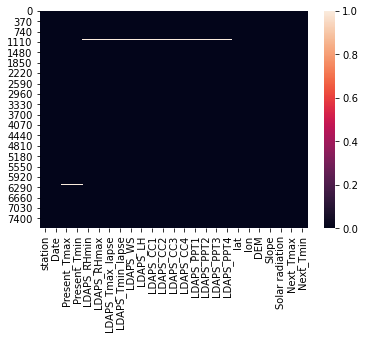

In [9]:
#Visualising null values
sns.heatmap(df.isna())

In [10]:
#Dropping null values

df.dropna(inplace = True)

In [11]:
#Rechecking for null values after treating them
df.isna().sum()

station             0
Date                0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

In [12]:
#Checking for Duplicate Values
df.duplicated().sum()

0

### Data Cleaning

In [13]:
df['Date']=pd.to_datetime(df['Date'])
df['Month']=df['Date'].apply(lambda x:x.month)
df['Day']=df['Date'].apply(lambda x:x.day)
df['Year']=df['Date'].apply(lambda x:x.year)

In [14]:
df.drop('Date', axis = 1, inplace = True)

### Multivariate Analysis

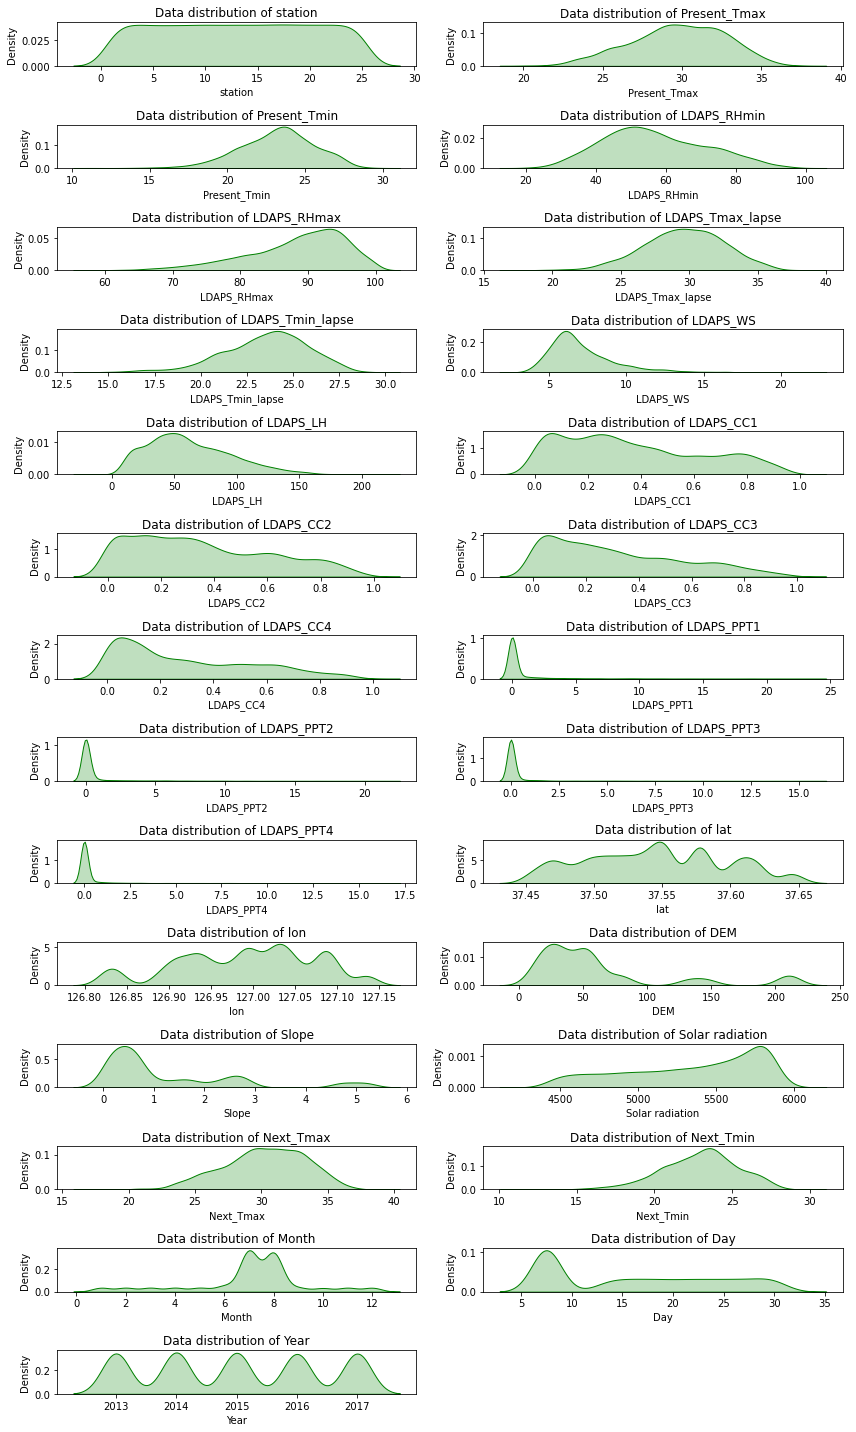

In [15]:
#Multivariate Analysis
#Visualising Data distribution of our dataset
plt.figure(figsize = (12,20), facecolor ='white')
plotnumber=1

for column in df:
    if plotnumber<=27: 
        ax = plt.subplot(14,2,plotnumber)
        sns.kdeplot(df[column], shade=True, color = 'green')
        plt.title('Data distribution of ' + column)
    plotnumber+=1
plt.tight_layout()

- There seems to be right- skewness in LDAPS, LDAPS_PPT1, LDAPS_PPT2, LDAPS_PPT3 and LDAPS_PPT4.
- Data seems to be normally distributed in other columns.

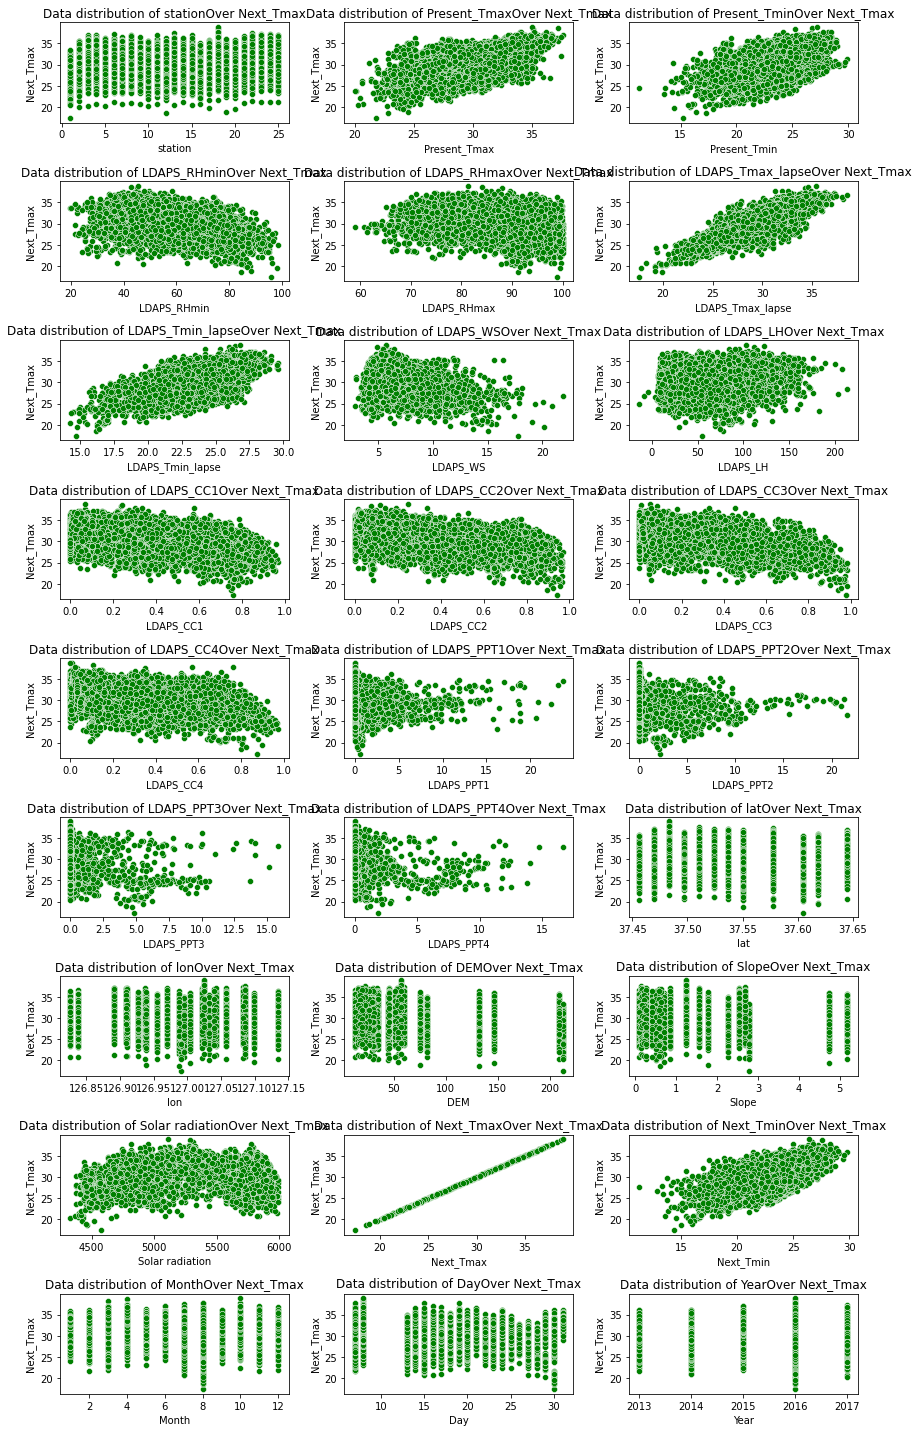

In [16]:
#Multivariate Analysis
#Visualising Data distribution of our dataset
plt.figure(figsize = (12,20), facecolor ='white')
plotnumber=1

for column in df:
    if plotnumber<=27: 
        ax = plt.subplot(9,3,plotnumber)
        sns.scatterplot(data = df, x =column, y = 'Next_Tmax' , color = 'green')
        plt.title('Data distribution of ' + column +'Over Next_Tmax')
    plotnumber+=1
plt.tight_layout()

- Present_Tmax, Present_Tmin, LDAPS_Tmax_lapse, LDAPS_TMin_Lapse and Next Tmax are all highly positively correlated with Next_Tmax.

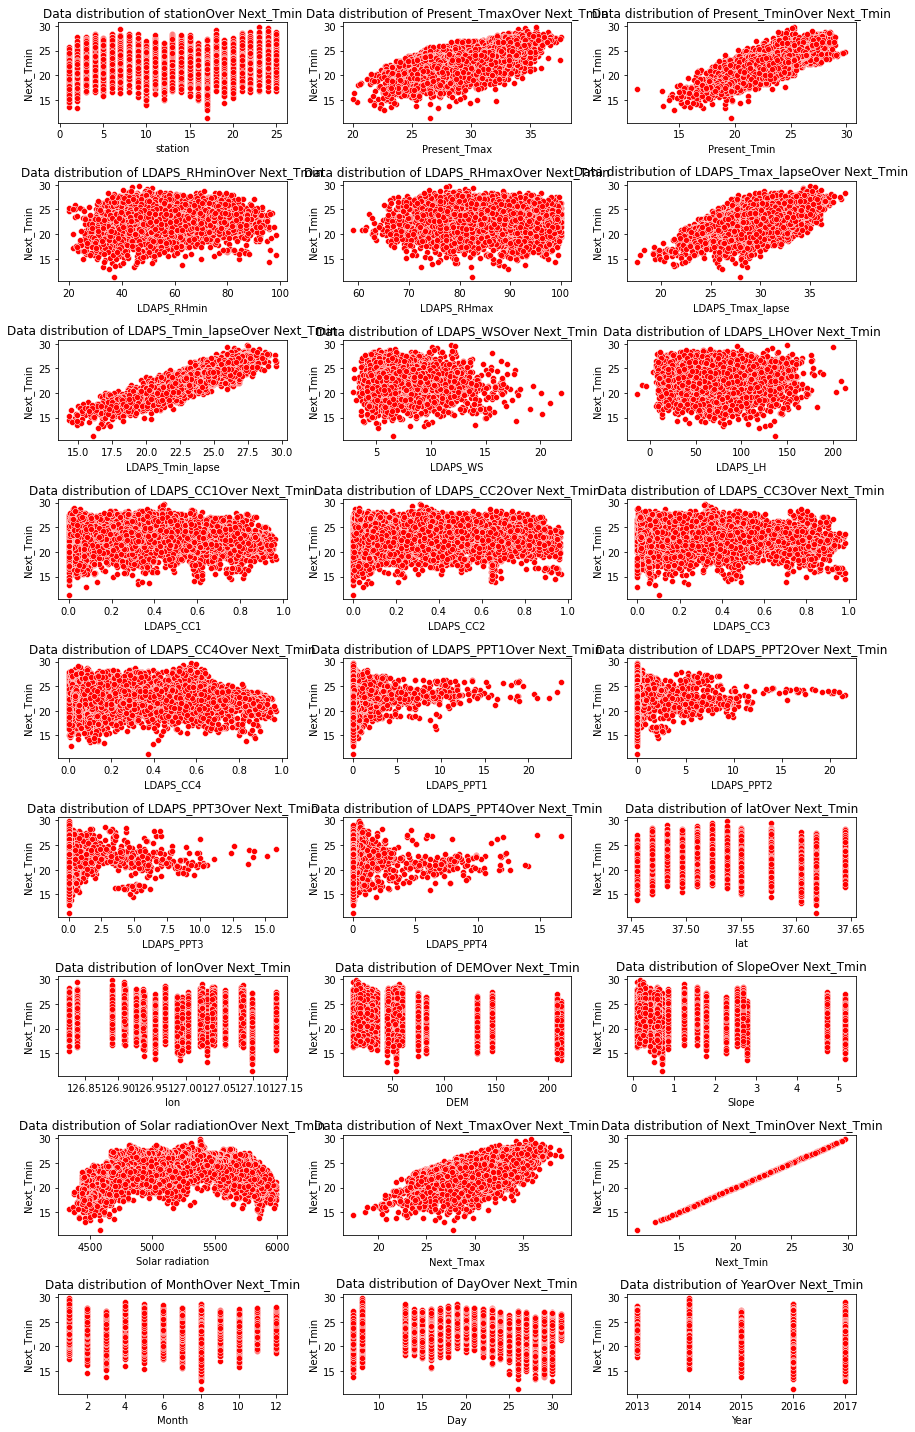

In [17]:
#Multivariate Analysis
#Visualising Data distribution of our dataset
plt.figure(figsize = (12,20), facecolor ='white')
plotnumber=1

for column in df:
    if plotnumber<=27: 
        ax = plt.subplot(9,3,plotnumber)
        sns.scatterplot(data = df, x =column, y = 'Next_Tmin' , color = 'red')
        plt.title('Data distribution of ' + column +'Over Next_Tmin')
    plotnumber+=1
plt.tight_layout()

- Present_Tmax, Present_Tmin, LDAPS_Tmax_lapse, LDAPS_TMin_Lapse and Next Tmax are all highly positively correlated with Next_Tmin.

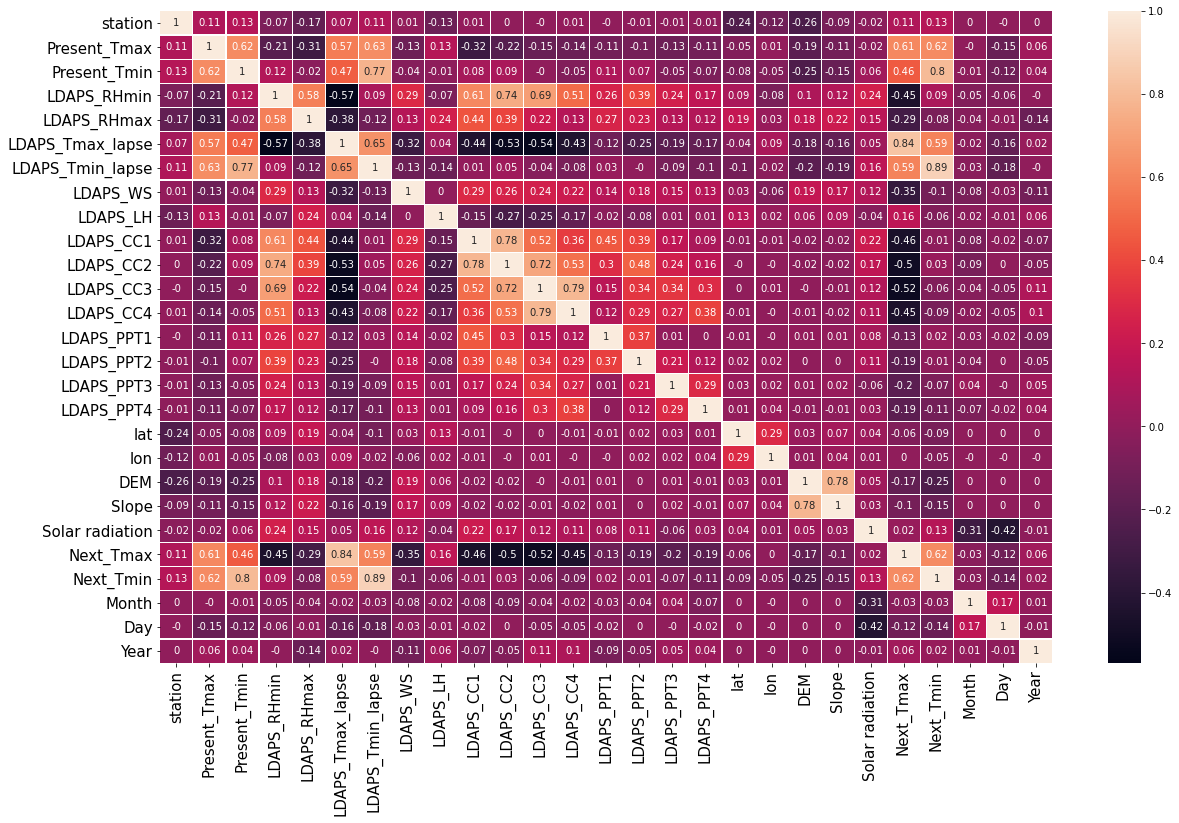

In [18]:
#plotting correlation table
plt.figure(figsize = [20,12])
sns.heatmap(round(df.corr(),2), annot = True,linewidths=0.1,fmt = '.5g' )
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

- Present_Tmax and Present T_min is moderately positive correlated.
- LDAPS_Tmax_lapse,LDAPS_Tmin_lapse , Present_Tmin and Present_Tmax are moderately positive correlated.
- LDAPS_CC1, LDAPS_CC2, LDAPS_CC3 and LDAPS_CC4 are all positively correlated.
- DEM and Slope are positively correlated.
- Next_Tmax, Next_Tmin, Present_Tmax and Present_Tmin are all correlated.


### Handling Skewness

In [19]:
df.skew()

station            -0.004178
Present_Tmax       -0.257069
Present_Tmin       -0.353822
LDAPS_RHmin         0.301396
LDAPS_RHmax        -0.845264
LDAPS_Tmax_lapse   -0.222349
LDAPS_Tmin_lapse   -0.574035
LDAPS_WS            1.553926
LDAPS_LH            0.662971
LDAPS_CC1           0.456716
LDAPS_CC2           0.473929
LDAPS_CC3           0.639649
LDAPS_CC4           0.663815
LDAPS_PPT1          5.305906
LDAPS_PPT2          5.710360
LDAPS_PPT3          6.356670
LDAPS_PPT4          6.681256
lat                 0.085377
lon                -0.289048
DEM                 1.721617
Slope               1.559050
Solar radiation    -0.524325
Next_Tmax          -0.334842
Next_Tmin          -0.393662
Month              -0.703092
Day                 0.245563
Year                0.013575
dtype: float64

station                AxesSubplot(0.125,0.808774;0.227941x0.0712264)
Present_Tmax        AxesSubplot(0.398529,0.808774;0.227941x0.0712264)
Present_Tmin        AxesSubplot(0.672059,0.808774;0.227941x0.0712264)
LDAPS_RHmin            AxesSubplot(0.125,0.723302;0.227941x0.0712264)
LDAPS_RHmax         AxesSubplot(0.398529,0.723302;0.227941x0.0712264)
LDAPS_Tmax_lapse    AxesSubplot(0.672059,0.723302;0.227941x0.0712264)
LDAPS_Tmin_lapse        AxesSubplot(0.125,0.63783;0.227941x0.0712264)
LDAPS_WS             AxesSubplot(0.398529,0.63783;0.227941x0.0712264)
LDAPS_LH             AxesSubplot(0.672059,0.63783;0.227941x0.0712264)
LDAPS_CC1              AxesSubplot(0.125,0.552358;0.227941x0.0712264)
LDAPS_CC2           AxesSubplot(0.398529,0.552358;0.227941x0.0712264)
LDAPS_CC3           AxesSubplot(0.672059,0.552358;0.227941x0.0712264)
LDAPS_CC4              AxesSubplot(0.125,0.466887;0.227941x0.0712264)
LDAPS_PPT1          AxesSubplot(0.398529,0.466887;0.227941x0.0712264)
LDAPS_PPT2          

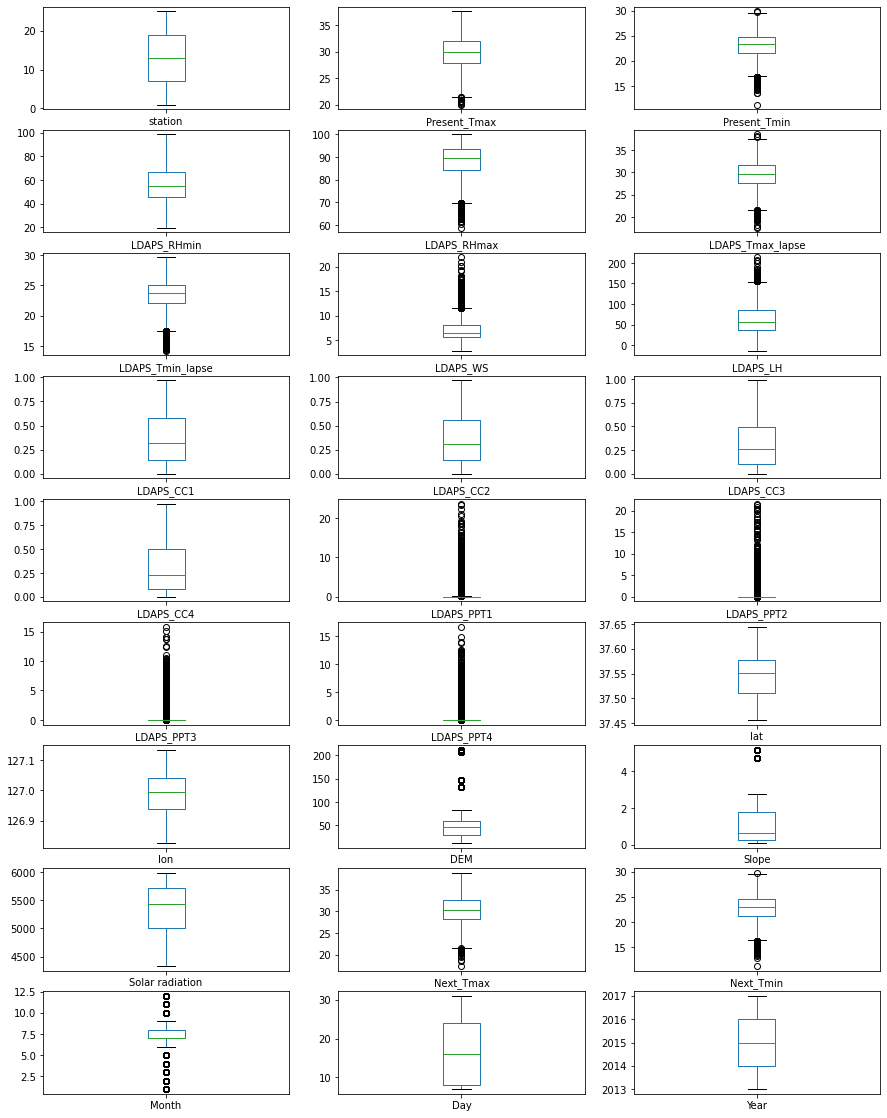

In [20]:
#Plotting Boxplot to analyse skewness 
df.plot(kind = 'box', subplots = True, layout = (9,3), figsize = (15,20))

In [21]:
# Splitting Dataset into Features and Target Variables

X = df.drop(columns =['Next_Tmax','Next_Tmin'], axis = 1)
y = df[['Next_Tmax','Next_Tmin']]

In [22]:
#Our dataset in not strictly positive that's why we are using Yeo-Johnson power transformation to remove skewness
pt = PowerTransformer(method='yeo-johnson')
X_trans = pd.DataFrame(pt.fit_transform(X), columns = X.columns)
X_trans.skew()

station            -0.206291
Present_Tmax       -0.036516
Present_Tmin       -0.014363
LDAPS_RHmin        -0.018008
LDAPS_RHmax        -0.120174
LDAPS_Tmax_lapse   -0.012155
LDAPS_Tmin_lapse   -0.021647
LDAPS_WS            0.005937
LDAPS_LH            0.028141
LDAPS_CC1           0.048221
LDAPS_CC2           0.047595
LDAPS_CC3           0.091156
LDAPS_CC4           0.129974
LDAPS_PPT1          1.451770
LDAPS_PPT2          1.637689
LDAPS_PPT3          1.814526
LDAPS_PPT4          2.041426
lat                 0.068584
lon                -0.202301
DEM                 0.039591
Slope               0.233968
Solar radiation    -0.182349
Month               0.043710
Day                -0.041461
Year                0.409648
dtype: float64

station                AxesSubplot(0.125,0.808774;0.227941x0.0712264)
Present_Tmax        AxesSubplot(0.398529,0.808774;0.227941x0.0712264)
Present_Tmin        AxesSubplot(0.672059,0.808774;0.227941x0.0712264)
LDAPS_RHmin            AxesSubplot(0.125,0.723302;0.227941x0.0712264)
LDAPS_RHmax         AxesSubplot(0.398529,0.723302;0.227941x0.0712264)
LDAPS_Tmax_lapse    AxesSubplot(0.672059,0.723302;0.227941x0.0712264)
LDAPS_Tmin_lapse        AxesSubplot(0.125,0.63783;0.227941x0.0712264)
LDAPS_WS             AxesSubplot(0.398529,0.63783;0.227941x0.0712264)
LDAPS_LH             AxesSubplot(0.672059,0.63783;0.227941x0.0712264)
LDAPS_CC1              AxesSubplot(0.125,0.552358;0.227941x0.0712264)
LDAPS_CC2           AxesSubplot(0.398529,0.552358;0.227941x0.0712264)
LDAPS_CC3           AxesSubplot(0.672059,0.552358;0.227941x0.0712264)
LDAPS_CC4              AxesSubplot(0.125,0.466887;0.227941x0.0712264)
LDAPS_PPT1          AxesSubplot(0.398529,0.466887;0.227941x0.0712264)
LDAPS_PPT2          

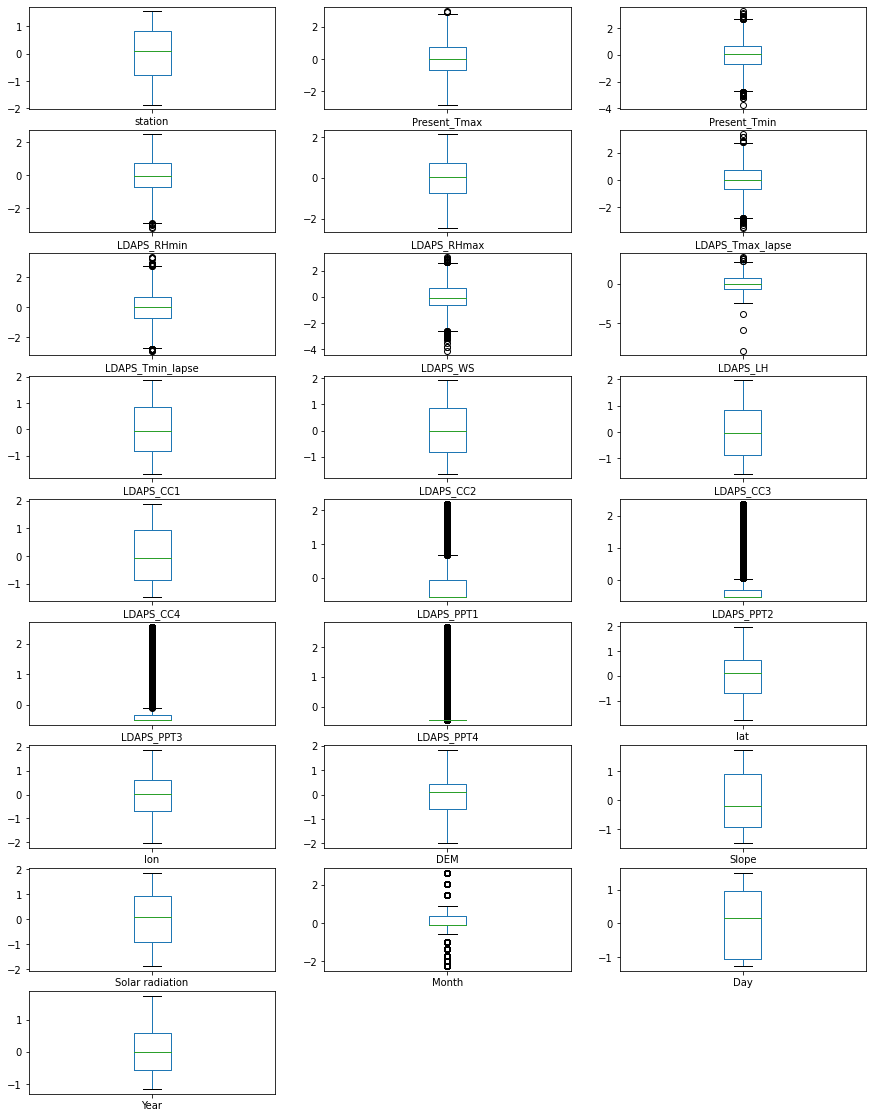

In [23]:
#Plotting Boxplot to analyse skewness 
X_trans.plot(kind = 'box', subplots = True, layout = (9,3), figsize = (15,20))

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()

In [26]:
X_Scaled = pd.DataFrame(scaler.fit_transform(X_trans), columns = X.columns)

In [27]:
X_Scaled

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Month,Day,Year
0,-1.857931,-0.400143,-0.785894,0.176401,0.271501,-0.556608,-0.311364,0.097802,0.318528,-0.407380,-0.499424,-0.533720,-0.577558,-0.560421,-0.521172,-0.4944,-0.447011,1.184346,-0.027876,1.833902,1.311979,1.852498,-0.575817,1.424006,-1.275907
1,-1.647078,0.709652,-0.708063,-0.237180,0.184890,0.041543,0.143619,-0.619344,-0.201095,-0.446317,-0.277218,-0.546143,-0.596343,-0.560421,-0.521172,-0.4944,-0.447011,1.184346,0.498499,0.055065,-0.387168,1.398583,-0.575817,1.424006,-1.275907
2,-1.454383,0.600750,-0.014024,-0.496590,-0.769141,0.124659,0.392812,-0.309297,-1.380242,-0.522163,-0.251723,-0.309696,-0.512901,-0.560421,-0.521172,-0.4944,-0.447011,0.653606,0.838708,-0.365481,-0.950272,1.378325,-0.575817,1.424006,-1.275907
3,-1.274154,0.746176,0.028619,0.175337,1.309753,-0.008668,-0.173951,-0.650457,0.213209,-0.488978,-0.395003,-0.536690,-0.558214,-0.560421,-0.521172,-0.4944,-0.447011,1.973712,0.368982,0.083964,1.233016,1.355226,-0.575817,1.424006,-1.275907
4,-1.103275,0.528707,-0.589813,0.035570,0.110434,-0.209847,-0.103645,-0.587672,1.292312,-0.808553,-0.285205,-0.440658,-0.358647,-0.560421,-0.521172,-0.4944,-0.447011,0.122279,1.876231,-0.291349,-0.403544,1.364282,-0.575817,1.424006,-1.275907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7583,1.076068,-2.067275,-2.051124,-2.612830,-1.375942,-0.642292,-1.960554,-0.023579,-1.969347,-1.355217,-1.449079,-1.588290,-1.439171,-0.560421,-0.521172,-0.4944,-0.447011,0.122279,0.602644,-0.722455,-0.281473,-1.734456,0.369512,1.424006,1.636898
7584,1.193770,-2.225156,-2.175999,-2.060276,-0.803558,-0.998728,-2.094605,-0.563635,0.660500,-1.274975,-1.484482,-1.588285,-1.335673,-0.560421,-0.521172,-0.4944,-0.447011,-0.683507,1.210750,-1.006916,-1.355268,-1.751541,0.369512,1.424006,1.636898
7585,1.310127,-2.013757,-2.267619,-2.395860,-1.319444,-1.109970,-1.824694,-0.302325,0.390795,-1.494541,-1.144487,-1.588290,-1.474031,-0.560421,-0.521172,-0.4944,-0.447011,-0.145730,-1.261421,-1.579065,-1.281031,-1.749736,0.369512,1.424006,1.636898
7586,1.425208,-2.013757,-2.082634,-2.683428,-1.462026,-0.901582,-1.837066,-0.058794,-0.352678,-1.458474,-1.179572,-1.588290,-1.474031,-0.560421,-0.521172,-0.4944,-0.447011,-0.414325,-1.044528,-1.401562,-1.073867,-1.755630,0.369512,1.424006,1.636898


## Model Building

In [28]:
#Using Train_test_Split for splitting training and testing data
X_train,X_test,y_train,y_test = train_test_split(X_Scaled,y,test_size = 0.20)

### Linear Regression

In [29]:
#Model Instantiating and Fitting

lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [30]:
#Printing model confidence on training set and testing set
print("Linear Regression Model Confidence on training set : ",round(lm.score(X_train,y_train)*100,2),'%')
print("Linear Regression Model Confidence on testing set : ",round(lm.score(X_test,y_test)*100,2),'%')

Linear Regression Model Confidence on training set :  80.53 %
Linear Regression Model Confidence on testing set :  80.13 %


In [31]:
#Performing Model Predictions on X_test
y_pred = lm.predict(X_test)

In [32]:
#printing Intercept and weights our Linear Regression Model
print("Intercept for Linear Regression Model is : ",lm.intercept_,'\n')
weights = zip(X.columns,lm.coef_)
weights = pd.DataFrame(list(weights), columns = ['features', 'coefficients'])
print("Features and their corresponding weights:")
weights

Intercept for Linear Regression Model is :  [30.24220368 22.90664215] 

Features and their corresponding weights:


,features,coefficients
0,station,"[0.17173937882387796, 0.503806528449227, 0.055..."
1,Present_Tmax,"[-0.0004249959537012947, 0.22913643983410895, ..."


In [33]:
#Applying Evaluation metrics to our Regression model
print('R squared for our Linear Regression Model:', r2_score(y_test,y_pred))
print('Mean Absolute Error for our Linear Regression Model:',mean_absolute_error(y_test,y_pred))
print('Mean Squared Error for our Linear Regression Model:',mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error for our Linear Regression Model:',np.sqrt(mean_squared_error(y_test,y_pred)))

R squared for our Linear Regression Model: 0.801263932582238
Mean Absolute Error for our Linear Regression Model: 0.9595095893147298
Mean Squared Error for our Linear Regression Model: 1.6353613450604545
Root Mean Squared Error for our Linear Regression Model: 1.2788124745483422


### Gradient Boosting Regressor

In [34]:
gbr = GradientBoostingRegressor()
model = MultiOutputRegressor(estimator=gbr)
print(model)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)


MultiOutputRegressor(estimator=GradientBoostingRegressor())


In [35]:
#Printing model confidence on training set and testing set
print("Multioutput Regressor Model Confidence on training set : ",round(model.score(X_train,y_train)*100,2),'%')
print("Multioutput Regresso Model Confidence on testing set : ",round(model.score(X_test,y_test)*100,2),'%')

Multioutput Regressor Model Confidence on training set :  89.61 %
Multioutput Regresso Model Confidence on testing set :  87.73 %


In [36]:
#Performing Model Predictions on X_test
mod_pred = model.predict(X_test)

In [37]:
#Applying Evaluation metrics to our Regression model
print('R squared for our Linear Regression Model:', r2_score(y_test,mod_pred))
print('Mean Absolute Error for our Linear Regression Model:',mean_absolute_error(y_test,mod_pred))
print('Mean Squared Error for our Linear Regression Model:',mean_squared_error(y_test,mod_pred))
print('Root Mean Squared Error for our Linear Regression Model:',np.sqrt(mean_squared_error(y_test,mod_pred)))

R squared for our Linear Regression Model: 0.8772551417600919
Mean Absolute Error for our Linear Regression Model: 0.7569305278528802
Mean Squared Error for our Linear Regression Model: 1.002040787592976
Root Mean Squared Error for our Linear Regression Model: 1.0010198737252802


### KNearest Neighbors Regressor

In [38]:
#Model fitting and Instantiating

knn = KNeighborsRegressor()
knn.fit(X_train,y_train)

KNeighborsRegressor()

In [39]:
print("Model Confidence on training Dataset: ",knn.score(X_train,y_train)*100,'%')
print("Model Confidence on test Dataset:",knn.score(X_test,y_test)*100,'%')

Model Confidence on training Dataset:  92.52817284717662 %
Model Confidence on test Dataset: 88.02315663519656 %


In [40]:
knnpred  = knn.predict(X_test)
#Applying Evaluation metrics to our KNN Regression model
print('R2 Score for KNN Regression Model:', r2_score(y_test,knnpred))
print('Mean Absolute Error for our KNN Regression Model:',mean_absolute_error(y_test,knnpred))
print('Mean Squared Error for our KNN Regression Model:',mean_squared_error(y_test,knnpred))
print('Root Mean Squared Error for our KNN Regression Model:',np.sqrt(mean_squared_error(y_test,knnpred)))

R2 Score for KNN Regression Model: 0.8802315663519655
Mean Absolute Error for our KNN Regression Model: 0.7217984189723314
Mean Squared Error for our KNN Regression Model: 0.9467745718050078
Root Mean Squared Error for our KNN Regression Model: 0.9730234179119266


### Bagging Regressor

In [41]:
#Model Instantiating and fitting

bagging = BaggingRegressor()
bagging.fit(X_train,y_train)

BaggingRegressor()

In [42]:
print("Model Confidence on training Dataset: ",bagging.score(X_train,y_train)*100,'%')
print("Model Confidence on test Dataset:",bagging.score(X_test,y_test)*100,'%')

Model Confidence on training Dataset:  97.89203176039862 %
Model Confidence on test Dataset: 89.18467759094489 %


In [43]:
bgpred = bagging.predict(X_test)
#Applying Evaluation metrics to our Gradient Boostin Regresser model
print('R2 Score for Gradient Boostin Regresser Model:', r2_score(y_test,bgpred))
print('Mean Absolute Error for our Gradient Boostin Regresser Model:',mean_absolute_error(y_test,bgpred))
print('Mean Squared Error for our Gradient Boostin Regresser Model:',mean_squared_error(y_test,bgpred))
print('Root Mean Squared Error for our Gradient Boostin Regresser Model:',np.sqrt(mean_squared_error(y_test,bgpred)))

R2 Score for Gradient Boostin Regresser Model: 0.8918467759094488
Mean Absolute Error for our Gradient Boostin Regresser Model: 0.6954743083003951
Mean Squared Error for our Gradient Boostin Regresser Model: 0.857099209486166
Root Mean Squared Error for our Gradient Boostin Regresser Model: 0.9257965270436944


### Decision Tree Regressor

In [44]:
#Model instantiating and fitting

dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)

DecisionTreeRegressor()

In [45]:
print("Model Confidence on training Dataset: ",dt.score(X_train,y_train)*100,'%')
print("Model Confidence on test Dataset:",dt.score(X_test,y_test)*100,'%')

Model Confidence on training Dataset:  100.0 %
Model Confidence on test Dataset: 77.98793691766673 %


In [46]:
#Applying Evaluation metrics to our Regression model
prd = dt.predict(X_test)

print('R squared for our Linear Regression Model:', r2_score(y_test,prd))
print('Mean Absolute Error for our Linear Regression Model:',mean_absolute_error(y_test,prd))
print('Mean Squared Error for our Linear Regression Model:',mean_squared_error(y_test,prd))
print('Root Mean Squared Error for our Linear Regression Model:',np.sqrt(mean_squared_error(y_test,prd)))

R squared for our Linear Regression Model: 0.7798793691766672
Mean Absolute Error for our Linear Regression Model: 0.9533596837944655
Mean Squared Error for our Linear Regression Model: 1.7327733860342567
Root Mean Squared Error for our Linear Regression Model: 1.3163485047791321


### Random Forest Regressor

In [47]:
# Model Instantiating and fitting
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
pred = rf.predict(X_test)
r2_score(y_test,pred)

0.9067508570826133

In [48]:
print("Model Confidence on training Dataset: ",rf.score(X_train,y_train)*100,'%')
print("Model Confidence on test Dataset:",rf.score(X_test,y_test)*100,'%')

Model Confidence on training Dataset:  98.66499050081212 %
Model Confidence on test Dataset: 90.67508570826132 %


In [49]:
#Applying Evaluation metrics to our Regression model
print('R squared for our Random Forest Regressor Model:', r2_score(y_test,pred))
print('Mean Absolute Error for our Random Forest Regressor Model:',mean_absolute_error(y_test,pred))
print('Mean Squared Error for our Random Forest Regressor Model:',mean_squared_error(y_test,pred))
print('Root Mean Squared Error for our Random Forest Regressor Model:',np.sqrt(mean_squared_error(y_test,pred)))

R squared for our Random Forest Regressor Model: 0.9067508570826133
Mean Absolute Error for our Random Forest Regressor Model: 0.6402012516469044
Mean Squared Error for our Random Forest Regressor Model: 0.7404224318181823
Root Mean Squared Error for our Random Forest Regressor Model: 0.8604780251802961


### Linear SVR

In [51]:
model = LinearSVR()
# define the direct multioutput wrapper model
wrapper = MultiOutputRegressor(model)
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, X_Scaled, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.953 (0.019)


### Conclusion :
- Among all other models Random Forest Regressor Model seems to giving us high scores among all evaluation metrics : 
    - R_square Score: 0.90
    - MAE : 0.64
    - MSE : 0.74
    - RMSE : 0.86

### Hyperparameter Tuning our Best Model

In [52]:
param_grid = { 'min_samples_leaf' : [1,2,3,4],'min_samples_split' : [2,3,4,5],'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

In [53]:
#Instantiating Randomized SearchCV
randomcv = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 50, cv = 3, verbose=2, random_state=42)

In [54]:
#Fitting our Random Search CV
randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=12; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=12; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=12; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5; total t

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 10, None],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [5, 6, 7, 8, 9, 10, 11,
                                                         12, 13, 15]},
                   random_state=42, verbose=2)

In [55]:
#To check the best parameters to enhance model Accuracy
randomcv.best_params_

{'n_estimators': 13,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': True}

In [56]:
#Instantiating Our Final Model
Model = RandomForestRegressor(n_estimators = 13 ,max_features = 'log2', min_samples_split = 5,min_samples_leaf = 2, max_depth = None,bootstrap = True)

In [57]:
#Fitting our final Model
Model.fit(X_train,y_train)

RandomForestRegressor(max_features='log2', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=13)

In [58]:
print("Model Confidence on training Dataset: ",Model.score(X_train,y_train)*100,'%')
print("Model Confidence on test Dataset:",Model.score(X_test,y_test)*100,'%')

Model Confidence on training Dataset:  96.59465972602328 %
Model Confidence on test Dataset: 90.05847868566933 %


In [59]:
#Applying Evaluation metrics to our Tuned Random Forest Regression model
y_pred = Model.predict(X_test)

print('R2 Score for Tuned Random Forest Regression Model:', r2_score(y_test,y_pred))
print('Mean Absolute Error for our Tuned Random Forest  Regression Model:',mean_absolute_error(y_test,y_pred))
print('Mean Squared Error for our Tuned Random Forest  Regression Model:',mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error for our Random Forest Regression Model:',np.sqrt(mean_squared_error(y_test,y_pred)))

R2 Score for Tuned Random Forest Regression Model: 0.9005847868566933
Mean Absolute Error for our Tuned Random Forest  Regression Model: 0.6633217361799386
Mean Squared Error for our Tuned Random Forest  Regression Model: 0.7843885872590358
Root Mean Squared Error for our Random Forest Regression Model: 0.885657149950835


### Saving our Final Model

In [60]:
joblib.dump(Model,"TemperaturePredictionAnalysis.pkl")

['TemperaturePredictionAnalysis.pkl']

### Loading Our Final Model

In [61]:
Model = joblib.load("TemperaturePredictionAnalysis.pkl")

In [62]:
#predicting test data using loaded model and saving the results in a dataframe
prediction = Model.predict(X_test)
prediction = pd.DataFrame(prediction)

In [63]:
prediction

,0,1
0,27.082051,20.625769
1,33.318205,22.543974
2,32.009267,23.330513
3,35.087198,26.181319
4,31.469753,22.465522
...,...,...
1513,28.725321,23.494231
1514,26.078974,22.062692
1515,36.357051,26.968462
1516,29.586838,22.994658


In [64]:
#Converting the saved file into .csv format
prediction.to_csv('Results.csv',index = True)